<a href="https://colab.research.google.com/github/sumanpandey72/ASL_recognition/blob/main/ASL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install xgboost
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 215kB 18.1MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# standard imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import *
# pipelines
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
# data preparation
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE


In [7]:
df=pd.read_csv('/content/drive/MyDrive/Sign_language_google_collab/sign_mnist_train.csv')
print(df.shape)
df.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,197,195,196,195,197,196,195,196,196,196,200,199,196,198,197,197,198,197,197,198,198,198,199,198,198,195,195,195,197,196,197,197,199,199,198,198,198,197,202,...,111,90,91,60,163,216,209,212,212,212,213,213,211,211,209,211,214,211,186,191,201,204,197,171,158,154,145,126,105,85,84,65,182,213,211,212,212,213,213,213
1,0,142,144,144,146,147,149,150,151,153,154,155,156,156,157,158,159,160,162,163,163,164,163,164,166,166,167,167,168,142,144,145,147,149,150,151,152,154,155,155,...,109,92,151,179,179,180,181,181,182,182,182,182,153,152,180,214,197,191,194,196,183,161,158,159,162,152,137,121,92,128,178,179,179,180,181,182,182,182,183,183
2,0,198,200,201,200,199,198,198,197,198,199,199,199,199,199,198,197,196,195,194,194,192,192,192,191,189,187,187,187,200,202,201,201,201,200,201,201,201,200,200,...,101,150,153,155,157,160,160,162,164,166,168,168,106,106,105,104,102,147,181,187,176,168,159,145,113,96,74,53,80,100,100,99,99,98,99,98,100,100,101,100
3,0,231,232,234,237,238,241,243,244,248,249,249,250,251,251,249,249,251,254,253,254,254,253,254,254,253,254,254,254,233,234,234,237,240,242,244,246,249,250,250,...,85,85,90,70,115,255,255,255,255,255,255,255,239,178,182,181,171,163,151,143,134,123,115,104,95,92,91,86,83,83,90,66,199,255,255,255,255,255,255,255
4,0,147,149,150,152,153,153,152,153,154,154,153,152,153,152,151,152,151,150,150,148,148,148,148,147,145,146,145,144,148,149,152,153,153,154,154,154,154,154,154,...,92,154,170,166,166,165,165,164,166,158,151,137,167,169,166,189,224,226,180,70,186,195,176,155,137,120,111,108,92,126,174,165,166,165,166,169,167,133,135,140


Slicing column
x =  Pixel values (column 1 to 785)
y =  Label (column 0)

In [8]:
x_train = df.iloc[:,1:785]
y_train = df.iloc[:,0]
print(x_train)
print(y_train)

       pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
0         197     195     196     195  ...       212       213       213       213
1         142     144     144     146  ...       182       182       183       183
2         198     200     201     200  ...       100       100       101       100
3         231     232     234     237  ...       255       255       255       255
4         147     149     150     152  ...       167       133       135       140
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
27450     170     171     173     174  ...       207       207       206       206
27451     168     173     178     180  ...       219       216       215       214
27452     211     213     213     215  ...       255       187       127       114
27453     212     212     212     212  ...        71        83        64        71
27454     174     177     179     180  ...       195       193       190       189

[27

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y, random_state=42)

NameError: ignored

In [ ]:
x_test= np.asarray(x_test, dtype='float32')
y_test= np.asarray(y_test).reshape(-1,1)

In [ ]:
np.save('/content/drive/MyDrive/Sign_language_google_collab/x_test_new.npy', x_test)
np.save('/content/drive/MyDrive/Sign_language_google_collab/y_test_new.npy', y_test)

Value count of each labels


In [9]:
y_train.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

**Downsample all label to 950 images**

In [ ]:
x_train_downsampling, y_train_downsampling = make_imbalance(x_train, y_train, sampling_strategy={0: 950, 1: 950, 2: 950, 3: 950 , 4: 950, 5: 950, 6: 950, 7: 950, 8: 950, 
                                                                                                   10: 950, 11: 950, 12: 950, 13: 950, 14: 950, 15: 950, 16: 950, 
                                                                                                   17: 950, 18: 950, 19: 950, 20: 950, 21: 950, 22: 950, 23: 950, 24: 950},random_state=42)


In [ ]:
y_train_downsampling.value_counts()

15    950
14    950
16    950
1     950
17    950
2     950
18    950
3     950
19    950
4     950
20    950
5     950
21    950
6     950
22    950
7     950
23    950
8     950
24    950
10    950
11    950
12    950
13    950
0     950
Name: label, dtype: int64

**Upsampling to majority class size(1294)**

In [ ]:
def upsample_classes(data, target):
    
    lst = list(data[target].unique())
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    regroup = pd.concat(classes)
    maj_class = regroup[regroup[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    minority_classes = pd.concat(new_classes)
    upsample = pd.concat([regroup[regroup[target]==class_lab],minority_classes])

    return upsample

In [ ]:
train = pd.concat([x_train,y_train],axis=1)
train_balanced = (upsample_classes(train,'label'))
x_train_upsampling = train_balanced.drop(['label'],axis=1)
y_train_upsampling = train_balanced.label

In [ ]:
y_train_upsampling.value_counts()

15    1294
14    1294
16    1294
1     1294
17    1294
2     1294
18    1294
3     1294
19    1294
4     1294
20    1294
5     1294
21    1294
6     1294
22    1294
7     1294
23    1294
8     1294
24    1294
10    1294
11    1294
12    1294
13    1294
0     1294
Name: label, dtype: int64

**Upsampling using Synthetic Minority Oversampling Technique (SMOTE)**

In [10]:
smote = SMOTE(random_state = 42)
x_train_SMOTE, y_train_SMOTE = smote.fit_resample(x_train, y_train)

In [11]:
y_train_SMOTE.value_counts()

15    1294
14    1294
16    1294
1     1294
17    1294
2     1294
18    1294
3     1294
19    1294
4     1294
20    1294
5     1294
21    1294
6     1294
22    1294
7     1294
23    1294
8     1294
24    1294
10    1294
11    1294
12    1294
13    1294
0     1294
Name: label, dtype: int64

**convert and save dataframe to numpy array**

In [ ]:
x_train_downsampling = np.asarray(x_train_downsampling, dtype='float32')
y_train_downsampling = np.asarray(y_train_downsampling).reshape(-1,1)

In [ ]:
np.save('/content/drive/MyDrive/Sign_language_google_collab/x_train_downsampling.npy', x_train_downsampling)
np.save('/content/drive/MyDrive/Sign_language_google_collab/y_train_downsampling.npy', y_train_downsampling)

In [ ]:
x_train_upsampling = np.asarray(x_train_upsampling, dtype='float32')
y_train_upsampling = np.asarray(y_train_upsampling).reshape(-1,1)

In [ ]:
np.save('/content/drive/MyDrive/Sign_language_google_collab/x_train_upsampling.npy', x_train_upsampling)
np.save('/content/drive/MyDrive/Sign_language_google_collab/y_train_upsampling.npy', y_train_upsampling)

In [12]:
x_train_SMOTE = np.asarray(x_train_SMOTE, dtype='float32')
y_train_SMOTE = np.asarray(y_train_SMOTE).reshape(-1,1)

In [13]:
np.save('/content/drive/MyDrive/Sign_language_google_collab/x_train_SMOTE.npy', x_train_SMOTE)
np.save('/content/drive/MyDrive/Sign_language_google_collab/y_train_SMOTE.npy', y_train_SMOTE)

**Model training**

In [19]:
pip install livelossplot

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKerasTF
from sklearn.metrics import confusion_matrix,classification_report,confusion_matrix
from sklearn import metrics
import seaborn as sb

**Training using downsampling**

In [ ]:
x_test = np.load('/content/drive/MyDrive/Sign_language_google_collab/X_test.npy')
x_train_downsampling = np.load('/content/drive/MyDrive/Sign_language_google_collab/x_train_downsampling.npy')
y_test = np.load('/content/drive/MyDrive/Sign_language_google_collab/Y_test.npy')
y_train_downsampling = np.load('/content/drive/MyDrive/Sign_language_google_collab/y_train_downsampling.npy')

In [ ]:
x_train_downsampling,x_validate_downsampling,y_train_downsampling,y_validate_downsampling = train_test_split(x_train_downsampling,y_train_downsampling, test_size = 0.2, random_state = 12345)

In [ ]:
x_train_downsampling = x_train_downsampling.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_validate_downsampling = x_validate_downsampling.reshape(-1,28,28,1)

x_train_downsampling = x_train_downsampling/255.0
x_test = x_test/255.0
x_validate_downsampling = x_validate_downsampling/255.0

label = LabelBinarizer()
y_train_downsampling = label.fit_transform(y_train_downsampling)
y_test = label.fit_transform(y_test)
y_validate_downsampling = label.fit_transform(y_validate_downsampling)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 24, activation = 'softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 128)        

In [ ]:
model.compile(loss ='categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Sign_language_google_collab/model_weights_downsampling.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF(),checkpoint]

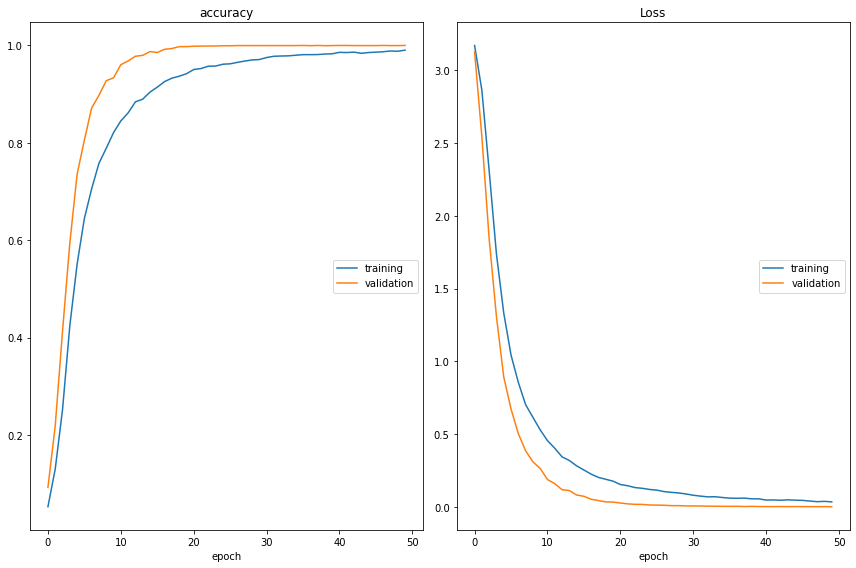

accuracy
	training         	 (min:    0.053, max:    0.990, cur:    0.990)
	validation       	 (min:    0.093, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.034, max:    3.171, cur:    0.034)
	validation       	 (min:    0.001, max:    3.127, cur:    0.001)

Epoch 00050: saving model to /content/drive/MyDrive/Sign_language_google_collab/model_weights_downsampling.h5


In [ ]:
history = model.fit(x_train_downsampling, y_train_downsampling, batch_size = 512, epochs = 50, verbose = 1, validation_data = (x_validate_downsampling, y_validate_downsampling),callbacks=callbacks)

In [ ]:
model.evaluate(x_test,y_test,verbose=0)

[0.18068256974220276, 0.9393474459648132]

In [ ]:
y_test=np.argmax(y_test, axis=1)
pred = model.predict_classes(x_test)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       0.88      0.98      0.93       310
           3       1.00      1.00      1.00       245
           4       0.94      1.00      0.97       498
           5       1.00      1.00      1.00       247
           6       0.93      0.79      0.86       348
           7       0.95      0.95      0.95       436
           8       0.88      1.00      0.94       288
           9       1.00      0.97      0.98       331
          10       1.00      0.99      0.99       209
          11       0.99      0.96      0.98       394
          12       0.95      0.98      0.96       291
          13       0.97      0.76      0.86       246
          14       0.97      1.00      0.98       347
          15       0.91      1.00      0.95       164
          16       0.77      0.85      0.81       144
          17       0.92    

Text(0.5, 145.31999999999996, 'Predicted label')

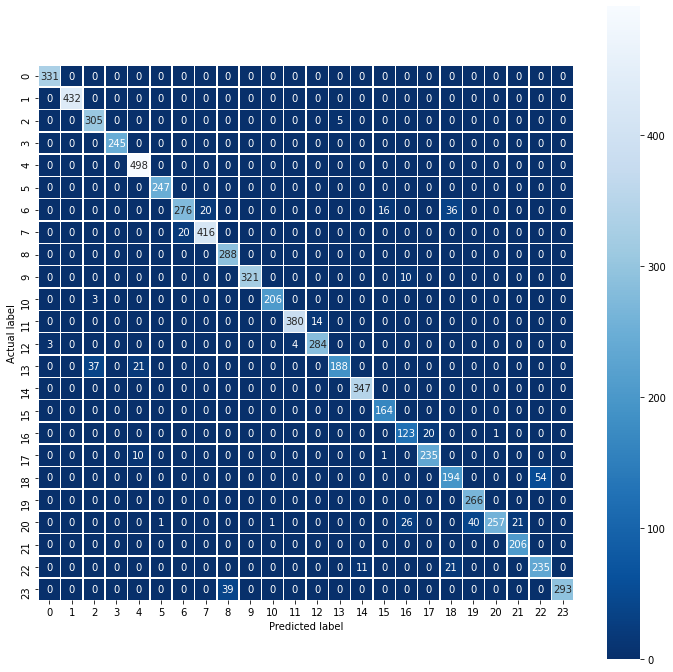

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred = pred)
plt.figure(figsize=(12,12))
sb.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Training using downsampling**

In [ ]:
x_test = np.load('/content/drive/MyDrive/Sign_language_google_collab/X_test.npy')
x_train_upsampling = np.load('/content/drive/MyDrive/Sign_language_google_collab/x_train_upsampling.npy')
y_test = np.load('/content/drive/MyDrive/Sign_language_google_collab/Y_test.npy')
y_train_upsampling = np.load('/content/drive/MyDrive/Sign_language_google_collab/y_train_upsampling.npy')

In [ ]:
x_train_upsampling,x_validate_upsampling,y_train_upsampling,y_validate_upsampling = train_test_split(x_train_upsampling,y_train_upsampling, test_size = 0.2, random_state = 12345)

In [ ]:
x_train_upsampling = x_train_upsampling.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_validate_upsampling = x_validate_upsampling.reshape(-1,28,28,1)

x_train_upsampling = x_train_upsampling/255.0
x_test = x_test/255.0
x_validate_upsampling = x_validate_upsampling/255.0

label = LabelBinarizer()
y_train_upsampling = label.fit_transform(y_train_upsampling)
y_test = label.fit_transform(y_test)
y_validate_upsampling = label.fit_transform(y_validate_upsampling)


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 24, activation = 'softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 3, 128)       

In [ ]:
model.compile(loss ='categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Sign_language_google_collab/model_weights_upscaling.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF(),checkpoint]

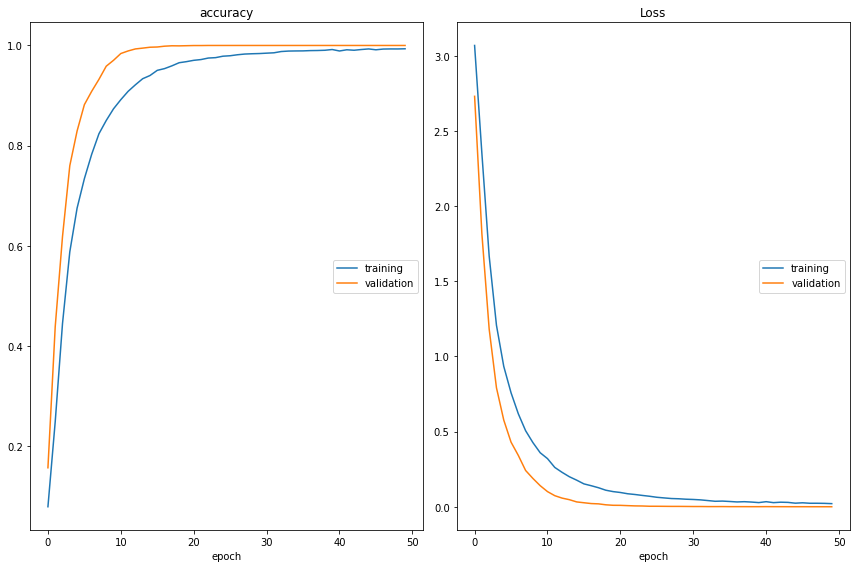

accuracy
	training         	 (min:    0.079, max:    0.993, cur:    0.993)
	validation       	 (min:    0.157, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.021, max:    3.070, cur:    0.021)
	validation       	 (min:    0.000, max:    2.731, cur:    0.000)

Epoch 00050: saving model to /content/drive/MyDrive/Sign_language_google_collab/model_weights_upscaling.h5


In [ ]:
history = model.fit(x_train_upsampling, y_train_upsampling, batch_size = 512, epochs = 50, verbose = 1, validation_data = (x_validate_upsampling, y_validate_upsampling),callbacks=callbacks)

In [ ]:
model.evaluate(x_test,y_test,verbose=0)

[0.1744036227464676, 0.9597043991088867]

In [ ]:
y_test=np.argmax(y_test, axis=1)
pred = model.predict_classes(x_test)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       0.94      1.00      0.97       310
           3       1.00      1.00      1.00       245
           4       0.99      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       0.94      0.88      0.91       348
           7       0.95      0.95      0.95       436
           8       0.88      1.00      0.94       288
           9       1.00      0.94      0.97       331
          10       0.92      1.00      0.96       209
          11       1.00      0.95      0.97       394
          12       0.96      1.00      0.98       291
          13       1.00      0.90      0.95       246
          14       1.00      0.99      1.00       347
          15       1.00      1.00      1.00       164
          16       0.61      0.90      0.72       144
          17       0.96    

Text(0.5, 145.31999999999996, 'Predicted label')

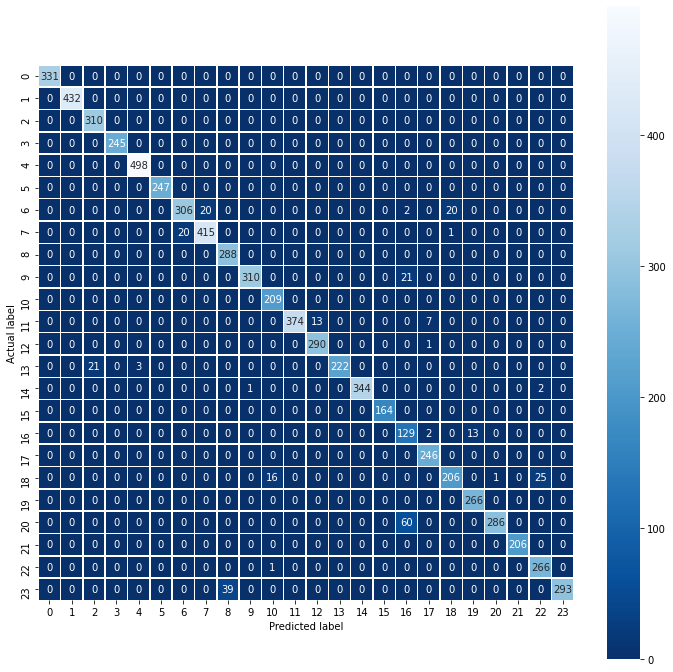

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred = pred)
plt.figure(figsize=(12,12))
sb.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Training using SMOTE**

In [21]:
x_test = np.load('/content/drive/MyDrive/Sign_language_google_collab/x_test_deploy.npy')
x_train_SMOTE = np.load('/content/drive/MyDrive/Sign_language_google_collab/x_train_SMOTE.npy')
y_test = np.load('/content/drive/MyDrive/Sign_language_google_collab/y_test_deploy.npy')
y_train_SMOTE = np.load('/content/drive/MyDrive/Sign_language_google_collab/y_train_SMOTE.npy')

In [22]:
x_train_SMOTE,x_validate_SMOTE,y_train_SMOTE,y_validate_SMOTE = train_test_split(x_train_SMOTE,y_train_SMOTE, test_size = 0.2, random_state = 12345)

In [23]:
x_train_SMOTE = x_train_SMOTE.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_validate_SMOTE = x_validate_SMOTE.reshape(-1,28,28,1)

x_train_SMOTE = x_train_SMOTE/255.0
x_test = x_test/255.0
x_validate_SMOTE = x_validate_SMOTE/255.0

label = LabelBinarizer()
y_train_SMOTE = label.fit_transform(y_train_SMOTE)
y_test = label.fit_transform(y_test)
y_validate_SMOTE = label.fit_transform(y_validate_SMOTE)


In [24]:
print(y_test)

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [25]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 24, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [26]:
model.compile(loss ='categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

In [27]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Sign_language_google_collab/model_weights_SMOTE.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF(),checkpoint]

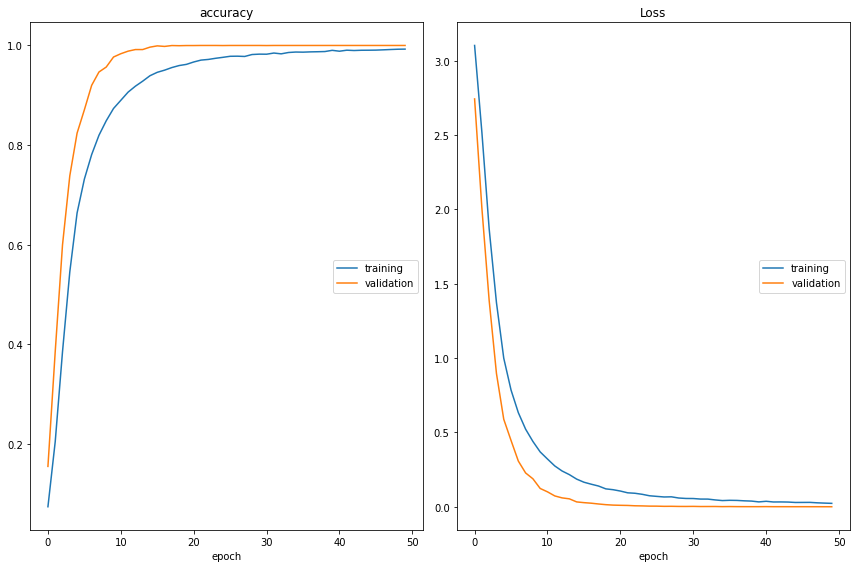

accuracy
	training         	 (min:    0.074, max:    0.993, cur:    0.993)
	validation       	 (min:    0.155, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.023, max:    3.104, cur:    0.023)
	validation       	 (min:    0.000, max:    2.744, cur:    0.000)

Epoch 00050: saving model to /content/drive/MyDrive/Sign_language_google_collab/model_weights_SMOTE.h5


In [28]:
history = model.fit(x_train_SMOTE, y_train_SMOTE, batch_size = 512, epochs = 50, verbose = 1, validation_data = (x_validate_SMOTE, y_validate_SMOTE),callbacks=callbacks)

In [29]:
model.evaluate(x_test,y_test,verbose=0)

[14.270858764648438, 0.035052910447120667]

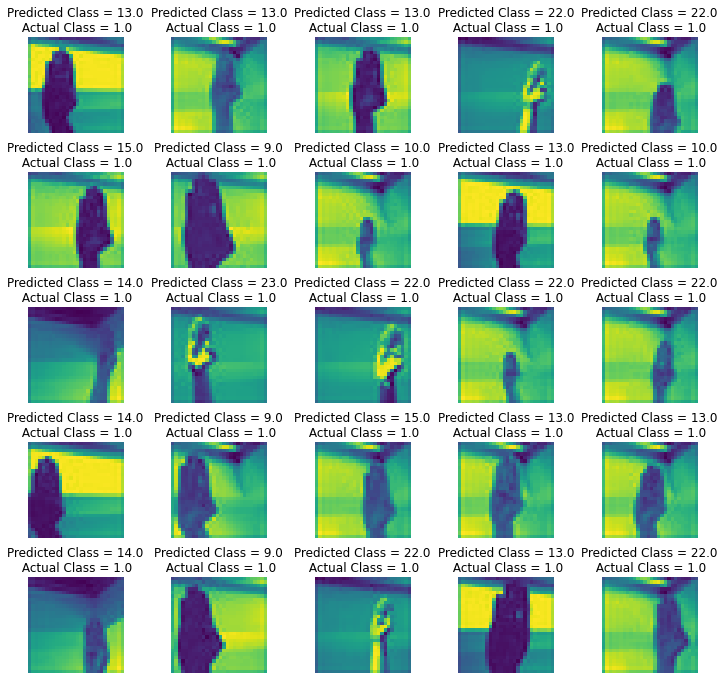

In [35]:
#y_test=np.argmax(y_test, axis=1)
pred = model.predict_classes(x_test)

fig, a = plt.subplots(5, 5, figsize = (12,12))
a = a.ravel()
test_len = len(x_test)
for i in np.arange(0, 25):
    index = np.random.randint(0, test_len)
    a[i].imshow(x_test[index].reshape(28,28))
    a[i].set_title(f"Predicted Class = {pred[index]:0.1f}\n Actual Class = {y_test[index]:0.1f}")
    a[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [31]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.03      0.06      3001
           2       0.00      1.00      0.01         1
           3       0.50      1.00      0.67         1
           4       0.03      1.00      0.06         1
           5       0.00      1.00      0.01         1
           6       1.00      1.00      1.00         1
           7       0.02      1.00      0.04         1
           8       1.00      1.00      1.00         1
           9       0.01      1.00      0.01         1
          10       0.01      1.00      0.03         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      1.00      0.00         1
          15       0.00      1.00      0.01         1
          16       0.04      1.00      0.07         1
          17       0.33    

Text(0.5, 145.31999999999996, 'Predicted label')

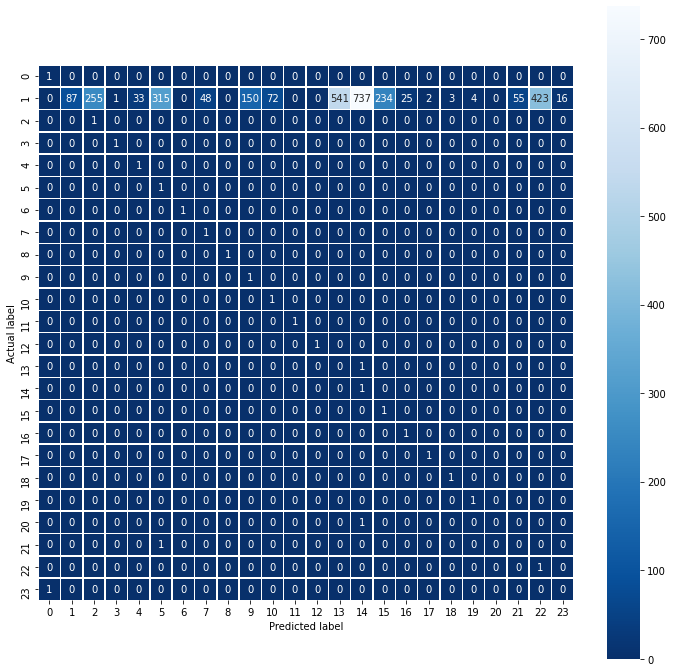

In [32]:
cm = confusion_matrix(y_true=y_test, y_pred = pred)
plt.figure(figsize=(12,12))
sb.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')